In [1]:
from datetime import datetime
import network
import time
import sys
import os
import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim
from utils import *
import matplotlib.pyplot as plt
%matplotlib inline

start_step = 1500
total_step = 2000
learning_rate = 0.000001
print_step = 10
summary_step = 100
val_step = 100
val_iteration = 10
snapshot_step = 100
batch_size = 256
image_size = 227

# g_data_folder = '/export/home/qliu24/qing_voting_139/CAE/dataset/cifar-10-batches-py'
# data_file = os.path.join(g_data_folder, 'data_batch_{0}')
dloader = Data_loader_imagenet('./imagenet_file_list.txt')

g_cache_folder = '/export/home/qliu24/qing_voting_139/CAE/cache/'
checkpoints_dir = os.path.join(g_cache_folder, 'checkpoints')
log_folder = os.path.join(g_cache_folder, 'log')

input_images = tf.placeholder(tf.float32, [batch_size, image_size, image_size, 3])
with tf.variable_scope('vgg_cae'):
    y, total_loss, z, merged, apply_gradient_op = network.vgg_cae(input_images, learning_rate = learning_rate)

restorer = tf.train.Saver([var for var in tf.global_variables()])
saver = tf.train.Saver()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
init_op = tf.global_variables_initializer()

print('done')

total number of images: 1281167
27 None
done


In [2]:
# start_step = 10000
# total_step = 10002

with tf.Session(config=config) as sess:
    print(str(datetime.now()) + ': Start Init')
    sess.run(init_op)
    # restorer.restore(sess, '/export/home/qliu24/qing_voting_139/CAE/cache/checkpoints_conv1/fine_tuned-1800')
    if start_step != 0:
        restorer.restore(sess, os.path.join(checkpoints_dir, 'fine_tuned-' + str(start_step)))
    
    print(str(datetime.now()) + ': Finish Init')
    
    train_writer = tf.summary.FileWriter(log_folder, graph=sess.graph)
    step = start_step + 1
    tf_time = 0
    while step <= total_step:
        batch_cur = dloader.get_batch(batch_size)
        
        time_before_tf = time.time()
        [out_loss, summary, _] = sess.run([total_loss, merged, apply_gradient_op], feed_dict={input_images: batch_cur})
        time_after_tf = time.time()
        tf_time += time_after_tf - time_before_tf

        if step % print_step == 0:
            print('{}: Iter {}: Training Loss = {:.5f}'.format(datetime.now(), step, out_loss))
            print('    where TF took {:.2f} seconds'.format(tf_time))
            tf_time = 0
        
        if step % summary_step == 0:
            train_writer.add_summary(summary, step)
        
        if step % snapshot_step == 0:
            saver.save(sess, os.path.join(checkpoints_dir, 'fine_tuned'), global_step=step)
        
        if step % val_step == 0:
            out_loss = []
            for vi in range(val_iteration):
                batch_eva = dloader.get_batch(batch_size,tp='eval')
                out_loss_i = sess.run(total_loss, feed_dict={input_images: batch_eva})
                out_loss.append(out_loss_i)
                
            print('{}: Iter {}: Evaluation Loss = {:.5f}'.format(datetime.now(), step, np.mean(out_loss)))
        
        step += 1
        if step == total_step:
            for vv in tf.trainable_variables():
                if vv.name == "vgg_cae/encoder_h1:0":
                    var_n = vv
                if vv.name == "vgg_cae/encoder_h2:0":
                    var_n2 = vv
                    
            print(var_n)
            weights = sess.run(var_n)
            print(weights.shape)
            weights2 = sess.run(var_n2)
            print(weights2.shape)
            
            batch_exp = dloader.get_batch(batch_size,tp='eval')
            batch_rec,out_loss = sess.run([y,total_loss], feed_dict={input_images: batch_exp})
            print(np.mean(np.sum(((batch_exp-batch_rec)**2).reshape(batch_exp.shape[0],-1), axis=1)))
            print(out_loss)
            

2017-06-16 12:48:30.900766: Start Init
INFO:tensorflow:Restoring parameters from /export/home/qliu24/qing_voting_139/CAE/cache/checkpoints/fine_tuned-1500
2017-06-16 12:48:31.323636: Finish Init
2017-06-16 12:49:49.636682: Iter 1510: Training Loss = 3065.26929
    where TF took 36.69 seconds
2017-06-16 12:50:40.547050: Iter 1520: Training Loss = 2939.85303
    where TF took 9.67 seconds
2017-06-16 12:51:31.752284: Iter 1530: Training Loss = 2998.72217
    where TF took 9.53 seconds
2017-06-16 12:52:24.462003: Iter 1540: Training Loss = 3123.85278
    where TF took 9.71 seconds
2017-06-16 12:53:15.886755: Iter 1550: Training Loss = 3006.74976
    where TF took 9.54 seconds
2017-06-16 12:54:06.269731: Iter 1560: Training Loss = 2968.77124
    where TF took 9.46 seconds
2017-06-16 12:54:58.338445: Iter 1570: Training Loss = 3015.55737
    where TF took 9.46 seconds
2017-06-16 12:55:49.964085: Iter 1580: Training Loss = 3006.87744
    where TF took 9.56 seconds
2017-06-16 12:56:41.767019: 

In [3]:
print(np.mean(np.sum(((batch_exp-batch_rec)**2).reshape(batch_cur.shape[0],-1), axis=1)))

3125.20927769


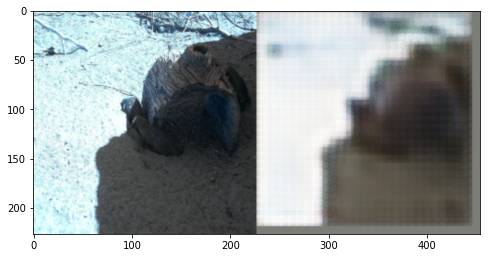

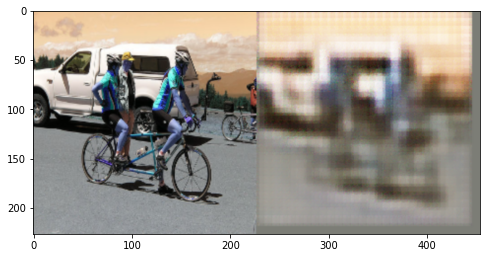

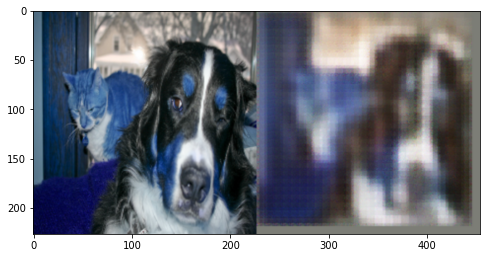

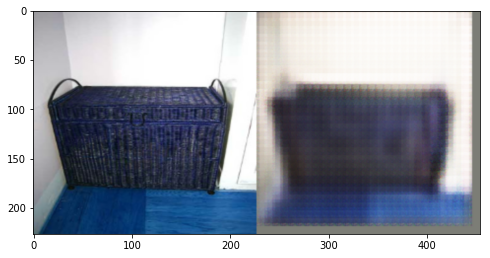

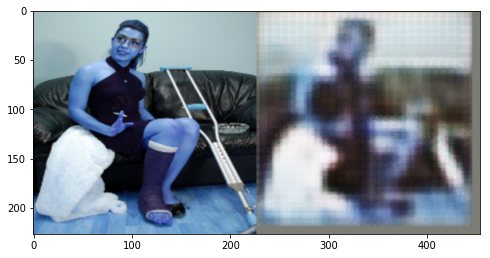

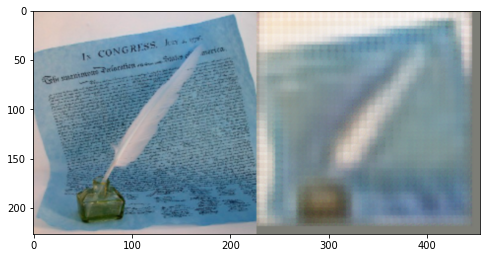

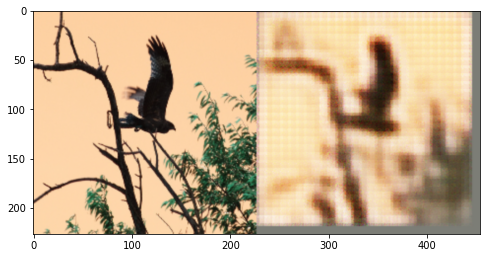

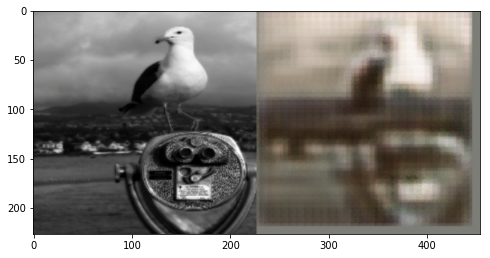

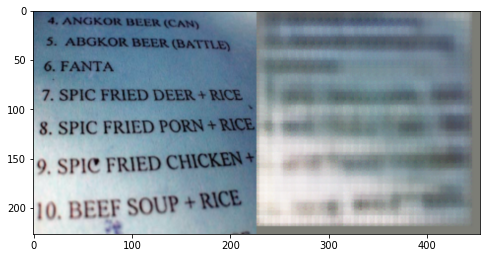

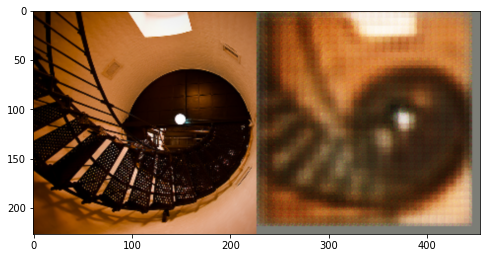

In [4]:
plt.rcParams['figure.figsize'] = (8.0, 5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

img_mean=np.float32([104., 117., 124.])
example_cur = batch_exp*255+img_mean.reshape(1,1,1,3)
example_rec = (batch_rec+0.5)*255
for bb in range(10):
    img = example_cur[bb].astype('uint8')
    img_r = example_rec[bb].astype('uint8')
    img_b = np.concatenate([img, img_r], axis=1)
    plt.imshow(img_b, cmap = 'gray', interpolation = 'bicubic')
    plt.show()


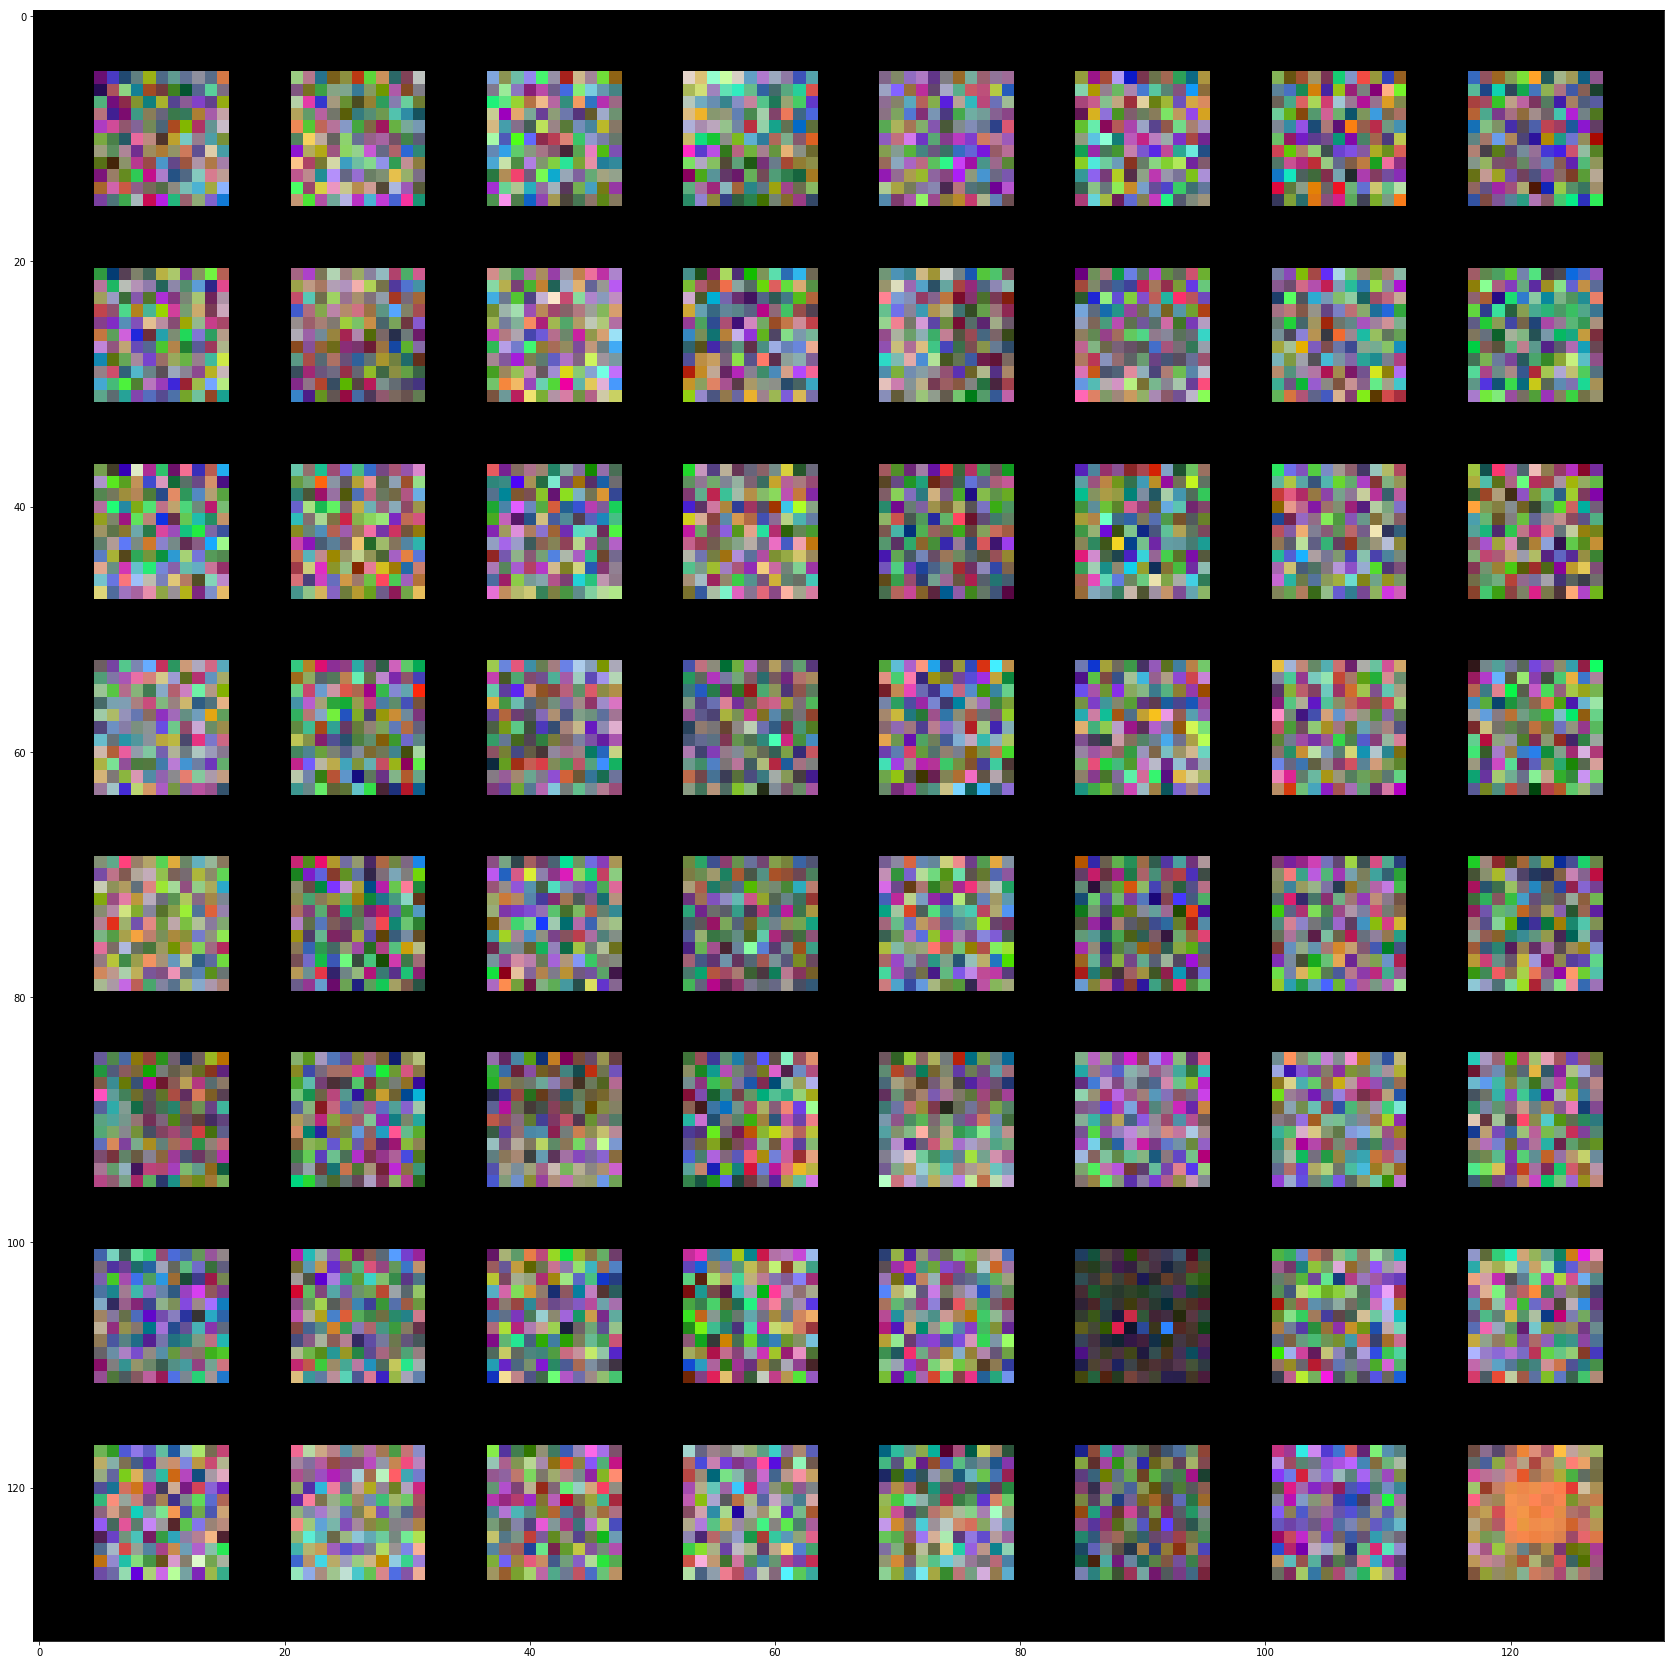

In [7]:
plt.rcParams['figure.figsize'] = (30.0, 30.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
canvas = np.zeros((133,133,3))
# weights_s = (weights-np.min(weights))/(np.max(weights)-np.min(weights))
for cc in range(64):
    # ff_s = weights_s[:,:,:,cc]
    ff = weights[:,:,:,cc]
    ff_s = (ff-np.min(ff))/(np.max(ff)-np.min(ff))
    aa = cc//8
    bb = cc%8

    row = 5+16*aa
    col = 5+16*bb
    canvas[row:row+11, col:col+11, :] = ff_s

plt.imshow(canvas, cmap = 'gray')
plt.show()

In [3]:
data_file_reg = os.path.join(g_data_folder, 'data_batch_{0}')
idx_ls=[1,2,3,4,5]
data_mat = np.zeros((0,3*32*32)).astype('uint8')
for ii in idx_ls:
    data_file = data_file_reg.format(ii)
    with open(data_file, 'rb') as fh:
        data_dict = pickle.load(fh, encoding='bytes')

    data_mat = np.concatenate([data_mat, data_dict[bytes('data', encoding='UTF-8')].astype('uint8')], axis=0)

totalN = data_mat.shape[0]
print('Total data loaded: {0}'.format(totalN))

Total data loaded: 50000


In [4]:
np.mean(data_mat[:,0:1024]), np.mean(data_mat[:,1024:2048]), np.mean(data_mat[:,2048:])

(125.306918046875, 122.95039414062499, 113.86538318359375)

In [9]:
img_mean=np.array([125.3, 122.9, 113.9])/255
rst=img_mean.reshape(-1,1).repeat(1024, axis=1).reshape(1,-1)

np.ones([10,1024*3])-rst

array([[ 0.50862745,  0.50862745,  0.50862745, ...,  0.55333333,
         0.55333333,  0.55333333],
       [ 0.50862745,  0.50862745,  0.50862745, ...,  0.55333333,
         0.55333333,  0.55333333],
       [ 0.50862745,  0.50862745,  0.50862745, ...,  0.55333333,
         0.55333333,  0.55333333],
       ..., 
       [ 0.50862745,  0.50862745,  0.50862745, ...,  0.55333333,
         0.55333333,  0.55333333],
       [ 0.50862745,  0.50862745,  0.50862745, ...,  0.55333333,
         0.55333333,  0.55333333],
       [ 0.50862745,  0.50862745,  0.50862745, ...,  0.55333333,
         0.55333333,  0.55333333]])

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
img_data = data_dict[bytes('data', encoding='UTF-8')].astype("uint8")
print(img_data.shape)
img = img_data[33].reshape(3,32,32)
img = img.transpose(1,2,0)
plt.imshow(img, interpolation='nearest')
plt.show()